In [206]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys,os
sys.path.append(os.path.realpath('..'))

from core.data import load_records

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
source = './records/macho/train'
batches = load_records(source, batch_size=100)

In [3]:
def create_padding_mask(tensor, lengths):
    ''' Create mask given a tensor and true length '''
    lengths_transposed = tf.expand_dims(lengths, 1)
    rangex = tf.range(0, tf.shape(tensor)[1], 1)
    range_row = tf.expand_dims(rangex, 0)
    # Use the logical operations to create a mask
    mask = tf.greater(range_row, lengths_transposed)
    return tf.cast(mask, tf.float32)

def create_prediction_mask(tensor, frac=0.15):
    time_steps = tensor.shape[1] 
    indices = tf.map_fn(lambda x: tf.random.shuffle(tf.range(time_steps))[:int(time_steps*frac)], 
                        tf.range(tensor.shape[0]))
    one_hot = tf.one_hot(indices, time_steps)
    mask    = tf.reduce_sum(one_hot, 1)
    return tf.cast(mask, tf.float32)

def create_mask(tensor, length=None):
    mask = create_prediction_mask(tensor)
    if length is not None:
        mask_1 = create_padding_mask(tensor, length)
        mask = tf.maximum(mask, mask_1)
        
    return mask

In [4]:
# plt.style.use('dark_background')

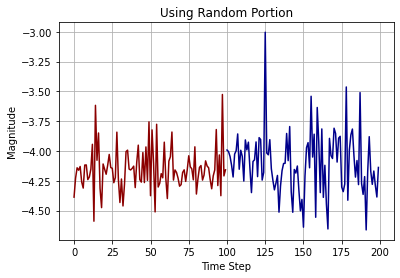

In [5]:
for i, (x1, x2, length, cls, std) in enumerate(batches):
    mask1 = create_mask(x1)
    mask2 = create_mask(x2)
    cls = tf.tile(cls, [1, 1])
    sep = tf.tile([[102.]], [x1.shape[0],1])
    mask = tf.concat([cls, mask1, sep, mask2], 1)
    dim_mask = tf.shape(mask)[1]
    mask = tf.tile(mask, [1, dim_mask])
    mask = tf.reshape(mask, [tf.shape(mask)[0], dim_mask, dim_mask])
    mask = tf.expand_dims(mask, 1)

    cls = tf.tile(tf.expand_dims(cls, 2), [1, 1, x1.shape[-1]])
    sep = tf.tile([[[102.]]], [x1.shape[0],1,x1.shape[-1]])
    inputs = tf.concat([cls, x1, sep, x2], 1)
    
    
    plt.figure()
   

    plt.plot(range(100), inputs[0][1:101, 1], color='darkred', label=cls)
    plt.plot(range(100, 200), inputs[0][102:, 1], color='darkblue', label=cls) 

    if cls.numpy()[0][0][0] == 0:
        plt.title('No Random Portion')
    else:
        plt.title('Using Random Portion')

    plt.xlabel('Time Step')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()
    if i == 0:break

# Exploring Positional Encoding

- Absolute positional encoding: the scale of these numbers is huge. If we have a sequence of 500 tokens, we’ll end up with a 500 in our vecto

- Normalizing the absolute positional encoding partially solves the problem. However, We can no longer deal with arbitrary sequence length. Since we are dividing by the `seq_length` encoding value 0.3 in a sequence with 5 observations means totally different than another one of length 20

- Using Binary System to codify seems to be a very good solution:
    - No values are grater than 1
    - Now each scalar will be a vector
    - We can deal with arbitrary length because each position will be associated to a vector

### From the binary vector to the continuous one

The binary positional encoding vector could has dfferent dimensions. Basically, the length of the vector ($d_{model}$) tell us the maximum length of our sequence. In this case, we can represent up to the $2^{d_{model}}$ position.

For similicity, we can choose $d_{model} = d_{input}$ (remember we should add them later).

Our binary vectors come from a discrete function, and not a discretization of a continous function. It is difficult to interpolate measurments!!!

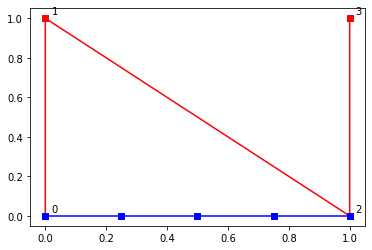

In [6]:
x = np.linspace(0, 1, 5)
x_bin = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

plt.plot(x_bin[:, 0], x_bin[:, 1], marker='s', label='Binary', color='red')

for k, pos in enumerate(x_bin): 
    plt.text(pos[0]+0.02, pos[1]+0.02, k,)
plt.plot(x, np.zeros_like(x), marker='s', label='Continuos', color='blue')

We use $\cos$ and $\sin$ function to interpolate a back and forth cycle $i.e., 0\rightarrow1\rightarrow 0\rightarrow1$.

Now we are able to codify $2^{d_{model}}$ which range from 0 to 1 and changes with different frequencies (sensitivity).


Lets consider a clock which has sec, min and hours. Every pointer will have different sensitivity.

A pointer cycle should be defined by $0 (00hrs)\rightarrow 1(6hrs)\rightarrow0 (00hrs)$.

Now we say that:
- The hour pointer $\pi/2$

If we have 3 vectors the first should shift $0\rightarrow 1$ and back every time we move one step in the sequence. It means a frequency of $\pi/2$

\begin{equation}
PE_{pos, 2i} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right), \hspace{5mm}
PE_{pos, 2i + 1} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)
\end{equation}

- $d_{model}$ = Input dimension 
- $i$ = Dimension
- $pos$ = Position

In [7]:
X = tf.random.normal([3, 5, 4])
X

<tf.Tensor: shape=(3, 5, 4), dtype=float32, numpy=
array([[[-7.1408594e-01, -1.7271347e+00, -1.8065423e-01, -8.7970302e-02],
        [ 1.6812077e+00,  1.2083333e+00, -6.8053976e-03,  1.1548032e+00],
        [-1.3016371e-01,  9.8043895e-01, -6.7717546e-01, -1.9152409e-01],
        [ 8.2341576e-01,  4.7632521e-01,  9.8548420e-02,  1.0043654e+00],
        [-5.8070862e-01, -7.4183732e-01,  1.0139784e+00,  1.9867238e+00]],

       [[ 8.6396170e-01,  1.7606672e+00, -5.9149200e-01, -1.0288352e+00],
        [ 9.2690103e-02,  8.4153336e-01,  3.0115500e-01,  7.3556203e-01],
        [-1.3824060e+00, -1.3774572e-01, -2.7010418e-02, -1.7408704e+00],
        [ 4.8345309e-01,  8.8101608e-01, -8.9680982e-01, -8.1865788e-01],
        [ 3.4081158e-01, -3.1068611e-01,  4.7901970e-01, -1.0024886e-01]],

       [[-7.2157753e-01, -1.1491572e+00,  1.9350684e-01, -2.8949264e-01],
        [ 1.7124319e+00,  1.6885321e+00, -6.0985661e-01, -3.3019346e-01],
        [ 4.8626855e-01,  7.5361395e-01, -1.0799956e+00, 

In [8]:
x_transpose = tf.transpose(X, [2,1,0])
indices = tf.range(0, tf.shape(x_transpose)[0])

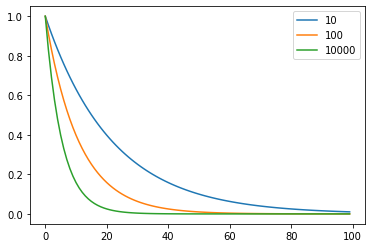

In [29]:
dim_model = 100
for b in [10, 100, 10000]:
    w = [1/(b**(2*i/dim_model)) for i in range(dim_model)]
    plt.plot(w, label=b)
plt.legend()

In [153]:
def get_angles(times, d_model, base=10000):
    dim_indices = tf.range(d_model, dtype=tf.float32)
    
    exponent = tf.divide(tf.multiply(2., tf.divide(dim_indices, 2.)), 
                         tf.cast(d_model, tf.float32))
    
    angle_rates = tf.pow(tf.cast(base, dtype=tf.float32), exponent)
    angle_rates = tf.math.reciprocal(angle_rates)
    angle_rates = times * angle_rates
    return angle_rates


def positional_encoding(batch, d_model, base=10000, mjd=False):
    times = tf.slice(batch, [0, 0, 0], [-1, -1, 1], name='times')
    if mjd:
        indices = times
    else:
        indices = tf.range(tf.shape(times)[1], dtype=tf.float32)
        indices = tf.expand_dims(indices, 0)
        indices = tf.tile(indices, [tf.shape(times)[0], 1])
        indices = tf.expand_dims(indices, 2)
    
    angle_rads = get_angles(indices,
                            d_model,
                            base)
    
    # SIN AND COS
    def fn(x):
        if x[1] % 2 == 0:
            return (tf.sin(x[0]), x[1])
        else:
            return (tf.cos(x[0]), x[1])
        
    x_transpose = tf.transpose(angle_rads, [2,1,0])
    indices = tf.range(0, tf.shape(x_transpose)[0])
    x_transpose = tf.map_fn(lambda x: fn(x),  (x_transpose, indices))[0]
    pos_encoding = tf.transpose(x_transpose, [2, 1, 0])
    return tf.cast(pos_encoding, dtype=tf.float32)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


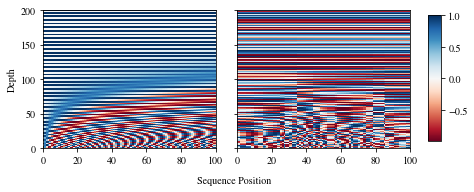

In [205]:
d_model = 200

fig, axes = plt.subplots(1, 2, figsize=(6, 2.5),sharey=True, sharex=True)

for x, _, _, _, _ in batches:
    pe_mjd = positional_encoding(x, d_model, base=10000, mjd=True)
    pe = positional_encoding(x, d_model, base=10000, mjd=False)
    
    # Get one
    singular = pe[0].numpy()
    singular_mjd = pe_mjd[0].numpy()
    
    # CHART
    pcc = axes[0].pcolormesh(singular.T, cmap='RdBu')
    pc = axes[1].pcolormesh(singular_mjd.T, cmap='RdBu')
    
    # Some parameters 
    axes[0].set_ylabel('Depth')    
    fig.text(0.55, -0.04, 'Sequence Position', ha='center')
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1, 0.19, 0.03, 0.7])
    fig.colorbar(pc, cax=cbar_ax)

    fig.tight_layout()
    fig.savefig('../plots/pe.pdf', format='pdf', bbox_inches='tight')
    break

In [134]:
singular.T.shape[0]

200

In [228]:
dots = tf.tensordot(tf.transpose(singular_mjd), tf.transpose(singular_mjd), [0, 0])

In [229]:
# dots = tf.tensordot(tf.transpose(singular), tf.transpose(singular), [0, 0])
# axes[0].plot(dots[0], label='1st component', linewidth=0.8)
# axes[0].plot(dots[-1], label='100th component', linewidth=0.8)

In [230]:
# np.stack([dots[0], dots[100]])

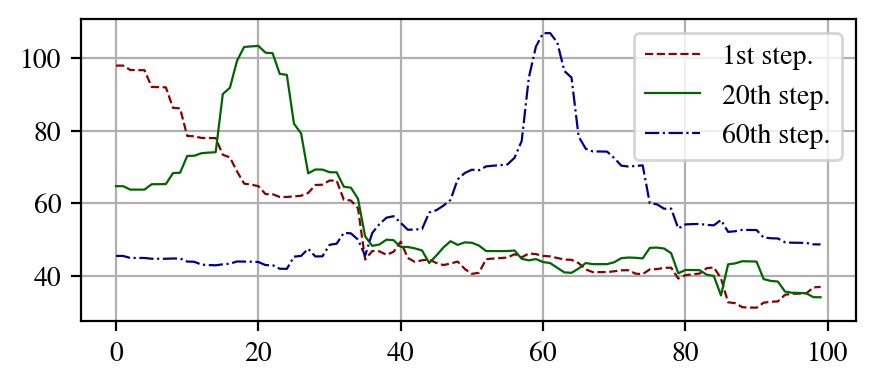

In [232]:
plt.figure(dpi=200, figsize=(5,2))
# plt.pcolormesh(np.stack([dots[0], dots[100]]),  cmap='RdBu')
plt.plot(dots[0], label='1st step.', linestyle='--',linewidth=0.8, color='darkred')
# plt.plot(dots[10], label='10th comp.', linestyle=':',linewidth=0.8)
plt.plot(dots[20], label='20th step.', linestyle='-',linewidth=0.8, color='darkgreen')
plt.plot(dots[60], label='60th step.', linestyle='-.',linewidth=0.8, color='darkblue')
plt.legend()
plt.grid()
plt.savefig('../plots/dotprod.pdf', format='pdf', bbox_inches='tight')

\begin{equation}
\prod_i\prod_k depth(i) \cdot depth(k)
\end{equation}